# Cone Calorimeter Paint

This document is meant to provide an example of how to use the functionality provided in the `ConeCalorimeterPaint.py` script.

In [1]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

# sns.set(style="darkgrid")
%matplotlib inline

from importlib import reload
from scipy import constants as const
from scipy.signal import argrelextrema


import ConeCalorimeterPaint as CCP

reload(CCP)

<module 'ConeCalorimeterPaint' from 'D:\\Git\\UsefulStuff\\LabEquipment\\ConeCalorimeterPaint\\ConeCalorimeterPaint.py'>

In [2]:
# Directory used to collect the output produced by this notebook.
output_dir = "ConeCalorimeterPaint"
if not os.path.isdir(output_dir):
    os.mkdir(output_dir)
    print("* Output directory created.")
else:
    print("* Output directory already exists.")

* Output directory already exists.


# Input of User Data

In [3]:
# Provide necessary information for the calculations.

# Example ignition times.
ign_times = [717.0, 681.0, 691.0, 50.0, 42.0, 53.0, 28.0]
heat_fluxes = [25,25,25,50,50,50,75]  # Test condition.

# File with Cone Calorimeter data.
cone_file = os.path.join('Experiment', 'cable219_1-50.csv')


# Known information.
therm_cond = 0.1165  # k
density = 1175  # rho

# Alpha_s is taken from Ignition Handbook, as recommended value.
alpha_s = 0.88


# Heat transfer coefficient, in kW/(m²K), 
# for 50 mm distance and 50 kW external flux.
# Lumpes together convective and radiative heat transfer
# thus, is an effective heat transfer coefficient.
h_c = 0.013 


# Room temperature during the test, in Kelvin.
# Assumed to be 20°C.
T_infty = 293  # 20 + 273


# Stefan Boltzmann constant, in W/(m²K**4).
# Stefan_Boltzmann_const = 5.670*10**(-8)
# Stefan_Boltzmann_const = np.power(5.670, -8)
# Stefan_Boltzmann_const = 5.67E-11  # kW
Stefan_Boltzmann_const = const.Stefan_Boltzmann/1000


# Test value from T. Beji and B. Merci paper.
q_crit_test = 14.5

# Janssens' Procedure

Janssens' Procedure is described in e.g. the Ignition Handbook, chapter 7, p.260, by Babrauskas. The individual steps (p. 261, top right) to retrieve the surface ignition temperature and thermophysical material parameters to simulate the heat up of the material, are performed below.

## 1. Find Ignition Times from HRR Data Series

In [4]:
# Determine the transformed ignition times.
transformed_ign_t = list()
for ign_time in ign_times:
    transformed_ign_t.append(CCP.transform_t(ign_time))

# Check results.
transformed_ign_t

[0.02688217873910332,
 0.027654708715657533,
 0.027433869849399217,
 0.11629646063455595,
 0.12800086080374784,
 0.11262849262297527,
 0.15997903867748484]

## 2. and 3. Determine Critical Irradiance q"_crit (Linear Regression)

In [5]:
# Calculate linear fit for the provided data.
x = np.array(heat_fluxes)
y = transformed_ign_t

lin_paras = np.polyfit(x, y, 1)
lin_paras

array([ 0.00290635, -0.03900414])

In [6]:
# Calculate data for plot of linear fit.

# Plot limits in x.
upper_limit = 80
lower_limit = 10

# Initialise list for result collection.
linear_fit_data = list()

x_vals = list()
y_vals = list()

# Create data series.
for irradiance in np.linspace(lower_limit, upper_limit, 
                              num=upper_limit - lower_limit +1):
    x_vals.append(irradiance)
    
    m_ign = lin_paras[0]
    b_ign = lin_paras[1]
    y_val = m_ign * irradiance + b_ign
    y_vals.append(y_val)
    
linear_fit_data.append(x_vals)
linear_fit_data.append(y_vals)

# Check result.
irr_crit = (-b_ign)/m_ign
print("* Critical flux for ignition: {} kW/m²".format(irr_crit))

* Critical flux for ignition: 13.420324052791196 kW/m²


### Plot "Transformed Ignition Time" Against Irradiance Level

The linear functions were built by a polynomial fit through the data points of a given series - either the minimum of centre ignition times.

Intersections with the x-axis are taken as the critical radiative heat fluxes for ignition. It is possible to obtain better values, by testing what the actual lowest irradiance level for ignition is. However, this kind of data is not available here, thus the critical flax was used.

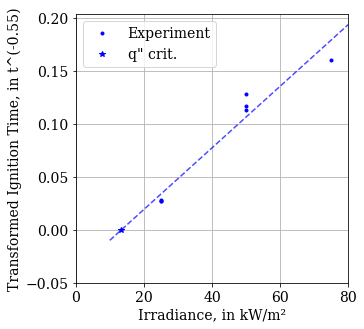

In [7]:
# Define data to be plotted.
plot_file_name = 'CriticalHeatFlux_Guess.png'


# Set figure and font size. 
scaling = 0.88
fontsize = 14

plt.rcParams.update({'font.size': fontsize})
plt.rcParams.update({'font.family': 'serif'})

fig = plt.figure(figsize=(6.0*scaling,
                          5.5*scaling))

# Data points.
# 25 kW/m²
plt.plot(25, CCP.transform_t(ign_times[0]),
         linestyle='none', marker='.', color='b',
         label='Experiment')
plt.plot(25, CCP.transform_t(ign_times[1]),
         linestyle='none', marker='.', color='b',
         label='_no_label_')
plt.plot(25, CCP.transform_t(ign_times[2]),
         linestyle='none', marker='.', color='b',
         label='_no_label_')

# 50 kW/m²
plt.plot(50, CCP.transform_t(ign_times[3]),
         linestyle='none', marker='.', color='b',
         label='_no_label_')
plt.plot(50, CCP.transform_t(ign_times[4]),
         linestyle='none', marker='.', color='b',
         label='_no_label_')
plt.plot(50, CCP.transform_t(ign_times[5]),
         linestyle='none', marker='.', color='b',
         label='_no_label_')

# 75 kW/m²
plt.plot(75, CCP.transform_t(ign_times[6]),
         linestyle='none', marker='.', color='b',
         label='_no_label_')


# linear fit for center values.
plt.plot(linear_fit_data[0], 
         linear_fit_data[1],
         linestyle='--', color='b', alpha=0.7)
    
plt.plot(irr_crit, 
         0,  # Critical flux where x-axis intersects
         linestyle='none', marker='*', color='b',
         label='q" crit.')


plt.xlim(left=0, right=80)
plt.ylim(bottom=-0.05)

plt.xlabel('Irradiance, in kW/m²')
plt.ylabel('Transformed Ignition Time, in t^(-0.55)')

plt.legend()
plt.grid()
plt.tight_layout()

# Save file.
pfn = os.path.join(output_dir, 
                   plot_file_name)
plt.savefig(pfn, dpi=320);

## 4. Determine B_ig from the Slope

In [8]:
B_ig = CCP.B_ign(m_ign)
print('B_ig: ', B_ig)

B_ig:  344.07434227567336


## 5. Determine T_ig

The surface ignition temperatue is determined by trail-and-error by a relationship detailed under point 5 of the description in the Ignition Handbook

In [9]:
# Estimate the ignition time.
print('* Estimated ignition time:')
T_ig_Janssen = CCP.Janssens_T_ign(q_ext=irr_crit,
                                  h_coeff=h_c)

* Estimated ignition time:
Janssens' delta: 2.7778585368759545e-07
Janssens' T_guess: 628.9800000002706 K


## 6. Solve for h_eff

In [10]:
h_eff_Janssen = CCP.solve_h_eff(alpha_s, irr_crit,
                                T_ig_Janssen, T_infty)

print('h_eff, Janssen: ', h_eff_Janssen)

h_eff, Janssen:  0.03515056005252319


## 7. Compute "k rho c"

In [11]:
k_rho_c_Janssen = CCP.k_rho_c(h_eff_Janssen, 
                              B_ig, 
                              irr_crit)

print('k_rho_c minimum, Janssen: ', k_rho_c_Janssen)

k_rho_c minimum, Janssen:  0.8263421847732422


In [12]:
# Determine c from Janssens' procedure.
c_Janssen = k_rho_c_Janssen / (therm_cond * density)
print('c, Janssen: ', c_Janssen)

c, Janssen:  0.006036651884016014


# Read Cone Data

Based on the data of a Cone Calorimeter test a RAMP for FDS is created.

In [13]:
cone_data = pd.read_csv(cone_file)
cone_data.head()

,Time,HRR
0,0,-2.127972
1,1,-3.641206
2,2,-3.423353
3,3,-2.361974
4,4,0.007127


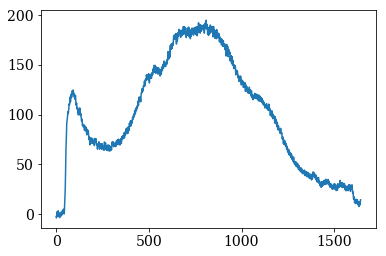

In [14]:
plt.plot(cone_data['Time'],
         cone_data['HRR'])

# Process Data

## Find Local Extrema

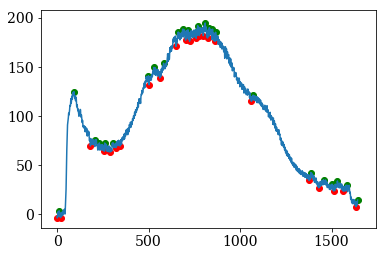

In [15]:
# Adopted from: 
# https://stackoverflow.com/questions/48023982/pandas-finding-local-max-and-min?rq=1

# number of points to be checked before and after 
n=15 

# Set DataFrame and desired column.
df = cone_data
column_label = 'HRR'

# Find local peaks
df['min'] = df.iloc[argrelextrema(df[column_label].values, 
                                  np.less_equal, 
                                  order=n)[0]][column_label]
df['max'] = df.iloc[argrelextrema(df[column_label].values, 
                                  np.greater_equal, 
                                  order=n)[0]][column_label]

# Plot results
plt.scatter(df.index, df['min'], c='r')
plt.scatter(df.index, df['max'], c='g')
plt.plot(df.index, df[column_label]);

## Interpolate Data

Data points: 1643


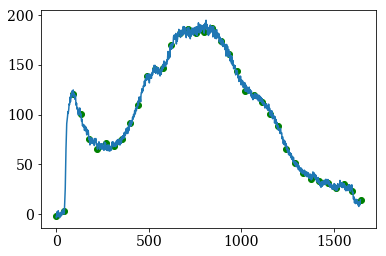

In [16]:
# Number of data points to be used for the RAMP.
n=38 

# Set DataFrame and desired column.
df = cone_data
column_label_x = 'Time'
column_label_y = 'HRR'

data_points = len(df[column_label_y])
print('Data points: {}'.format(data_points))

# Calculate the new x values to be used for the interpolation.
x_vals = np.linspace(0, data_points, n, endpoint=True)

# Interpolate the data series based on the new x-values.
# Incorporate the last data point (df.tail(1)).
interpolated_y = np.interp(x=x_vals,
                           xp=df[column_label_x],
                           fp=df[column_label_y], 
                           right=df[column_label_y].tail(1))

# Collect new data points in DataFrame.
ramp_df = pd.DataFrame({'Time': x_vals,
                        'HRR': interpolated_y})

# Plot results.
plt.scatter(ramp_df.Time, ramp_df.HRR, c='g')
plt.plot(df[column_label_x], df[column_label_y]);

## Combine Data Points

In [17]:
# Get local extrema.
local_extrema = [cone_data['min'].notnull(),
                 cone_data['max'].notnull()]

for extrema in local_extrema:
    for id_extr, extremum in enumerate(extrema):
        # Find location of extremum.
        if extremum:
            hrr_val = cone_data.iloc[id_extr]['HRR']
            
            # Prevent negative values to be chosen.
            if hrr_val < 0:
                new_time = cone_data.iloc[id_extr]['Time']
                new_hrr = np.float64(0.0)
            else:
                new_time = cone_data.iloc[id_extr]['Time'] 
                new_hrr = cone_data.iloc[id_extr]['HRR']
            
            # Create DataFrame of new row to be inserted into 
            # the DataFrame with the interpolated values.
            new_row = pd.DataFrame({'Time': new_time,
                                    'HRR': new_hrr},
                                   index=[0])
            
            # Add new row into the interpolated DataFrame.
            ramp_df = pd.concat([new_row, ramp_df]).reset_index(drop=True)             

# Force energy release to be 0 after data ends.
# Create DataFrame of new row to be inserted into 
# the DataFrame with the interpolated values.
new_row = pd.DataFrame({'Time': new_time+2,
                        'HRR': 0.0},
                       index=[0])

# Add new row into the interpolated DataFrame.
ramp_df = pd.concat([new_row, ramp_df]).reset_index(drop=True)  
            
# Sort DataFrame by the time values.
ramp_df = ramp_df.sort_values(by=['Time']).reset_index(drop=True) 

# Check.
ramp_df.tail()

,Time,HRR
81,1598.594595,22.842632
82,1634.000000,7.829619
83,1642.000000,14.563365
84,1643.000000,14.563365
85,1644.000000,0.000000


# Build FDS Input Based on Janssens' T_guess

In [20]:
hrrpua_max = cone_data['HRR'].max()
hrrpua_max

194.4652856

In [21]:
# Build MATL input.
matl_id_label = 'GreenStuff'
matl_min = CCP.matl_nucleus.format(matl_id_label,
                                   therm_cond,
                                   c_Janssen,
                                   density)

In [22]:
# Build SURF and RAMP input.
ramp_input = CCP.create_hrrpua_ramp(surf_id='GreenStuffSURF', 
                                    hrrpua=hrrpua_max, 
                                    time=ramp_df.Time-44.4054054054054,  # Offset the time  
                                    function_value=ramp_df.HRR,
                                    offset=4,
                                    ramp_id=None,
                                    spec_id='TOLUENE',
                                    matl_id=matl_id_label,
                                    color='GREEN',
                                    ignition_temp=T_ig_Janssen-273,
                                    thickness=0.02)

In [23]:
# Show results.

# MATL
print(matl_min)
print('\n')

# SURF and RAMP
for line in ramp_input:
    print(line)

&MATL ID = 'GreenStuff',
      CONDUCTIVITY = 0.1165,
      SPECIFIC_HEAT = 0.006036651884016014,
      DENSITY = 1175 /


&SURF ID = 'GreenStuffSURF',
      COLOR = 'GREEN',
      SPEC_ID(1) ='TOLUENE',
      HRRPUA = 194.4652856,
      RAMP_Q = 'BURNER_RAMP',
      IGNITION_TEMPERATURE = 355.9800000002706,
      MATL_ID = 'GreenStuff',
      THICKNESS = 0.02 /



&RAMP ID='BURNER_RAMP', T=0.0, F=0.01804669362735026/
&RAMP ID='BURNER_RAMP', T=44.4054054054054, F=0.6221015573327547/
&RAMP ID='BURNER_RAMP', T=47.5945945945946, F=0.6409995599749347/
&RAMP ID='BURNER_RAMP', T=88.81081081081079, F=0.5170179140175021/
&RAMP ID='BURNER_RAMP', T=133.2162162162162, F=0.39052567322364073/
&RAMP ID='BURNER_RAMP', T=137.59459459459458, F=0.3574368114881683/
&RAMP ID='BURNER_RAMP', T=164.59459459459458, F=0.3903871939187896/
&RAMP ID='BURNER_RAMP', T=177.6216216216216, F=0.33816748702177785/
&RAMP ID='BURNER_RAMP', T=186.59459459459458, F=0.3736312584316592/
&RAMP ID='BURNER_RAMP', T=213.594594594

## Check Result

Only used to provide an example to check the result. The main document ended above.

In [24]:
fds_hrr_file = os.path.join('ConePaintTest_50kW',
                            'ConePaintTest_50kW_hrr.csv')

fds_hrr_df = pd.read_csv(fds_hrr_file, header=1)
fds_hrr_df.head()

,Time,HRR,Q_RADI,Q_CONV,Q_COND,Q_DIFF,Q_PRES,Q_PART,Q_GEOM,Q_ENTH,Q_TOTAL,MLR_FUEL,MLR_TOTAL
0,0.000000,0.000000,-4.190175e-19,-5.551115e-20,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000e+00,-4.745286e-19,0.000000e+00,0.000000e+00
1,1.000000,0.000000,9.551347e-14,-5.697639e-10,1.363047e-11,0.000000e+00,0.0,0.0,0.0,-1.130237e-10,-5.560379e-10,-7.313816e-09,-7.313816e-09
2,2.000000,0.001781,2.092702e-11,3.028030e-05,-2.995445e-09,-4.135757e-08,0.0,0.0,0.0,-2.172260e-07,1.811610e-03,8.721473e-08,8.721473e-08
3,3.000000,0.004792,-4.030366e-04,7.098535e-05,-6.539951e-05,-8.274325e-08,0.0,0.0,0.0,1.771112e-03,4.394156e-03,1.756488e-07,1.756488e-07
4,4.107778,0.024112,-2.248069e-03,3.648448e-04,-4.844820e-04,-1.095434e-07,0.0,0.0,0.0,1.959918e-02,2.174423e-02,2.325494e-07,2.325494e-07


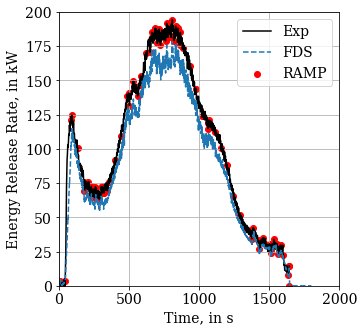

In [25]:
# Plot results

# Define data to be plotted.
plot_file_name = 'CCPaintCheck.png'

# Set figure and font size. 
scaling = 0.88
fontsize = 14

plt.rcParams.update({'font.size': fontsize})
plt.rcParams.update({'font.family': 'serif'})

fig = plt.figure(figsize=(6.0*scaling,
                          5.5*scaling))


# Experimental data.
plt.plot(df[column_label_x], 
         df[column_label_y], c='k',
         label='Exp')
# Data points of the RAMP.
plt.scatter(ramp_df.Time, ramp_df.HRR, 
            c='r', label='RAMP')
# Response from FDS.
plt.plot(fds_hrr_df.Time,
         fds_hrr_df.HRR/(0.1**2), 
         linestyle='dashed',
         label='FDS');


# Set meta information for plot.
plt.xlabel('Time, in s')
plt.ylabel('Energy Release Rate, in kW')

plt.xlim(0, 2000)
plt.ylim(0, 200)

plt.legend()
plt.grid()
plt.tight_layout()

# Save file.
pfn = os.path.join(output_dir, 
                   plot_file_name)
plt.savefig(pfn, dpi=320);